In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "../")
from leitmotifs.plotting import *

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

import warnings
warnings.simplefilter("ignore")

path = "../datasets/experiments/"

In [2]:
def read_penguin_data():
    series = pd.read_csv(path + "penguin.txt", 
                         names=(["X-Acc", "Y-Acc", "Z-Acc",
                                 "4", "5", "6",
                                 "7", "Pressure", "9"]),
                         delimiter="\t", header=None)
    ds_name = "Penguins"
    return ds_name, series

In [3]:
ds_name, series = read_penguin_data()
series = series.iloc[497699 + 60: 497699 + 500, [0,1,2,7]].T


motif_length = 22
knns = 5
D, knns = ml.compute_distance_matrix(series.values, motif_length, knns, sum_dims=False)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [4]:
linestyle_tuple = [
     (0, (1, 1)),
     (5, (10, 3)),
     # (0, (5, 5)),
     (0, (5, 1)),
     (0, (3, 10, 1, 10)),
     (0, (3, 5, 1, 5)),
     (0, (3, 1, 1, 1)),
     (0, (3, 5, 1, 5, 1, 5)),
     (0, (3, 10, 1, 10, 1, 10)),
     (0, (3, 1, 1, 1, 1, 1))]

def plot_data(data, motifsets=None, motif_length=None, dists=None, dists_knn=None):
    fig, axes = plt.subplots(4, 1, squeeze=False, figsize=(8, 10))
    
    data_index, data_raw = ml.pd_series_to_numpy(data)
    
    offset = 0
    offset2 = 0
    tick_offsets = []
    tick_offsets2 = []
    
    axes[0, 0].set_title(ds_name, fontsize=20)
    axes[1, 0].set_title("(a) k-NNs search", fontsize=20)
    axes[2, 0].set_title("(b) Sort dimensions by k-th NN distance", fontsize=20)
    axes[3, 0].set_title("(c) Select first f=2 dimensions", fontsize=20)    

    dim_order = np.argsort(dists_knn[:, -1])
    f = 2
    
    for dim in range(data_raw.shape[0]):
        dim_data_raw = zscore(data_raw[dim])
        offset -= 3*(np.max(dim_data_raw) - np.min(dim_data_raw))
        tick_offsets.append(offset)
    
        _ = sns.lineplot(x=data_index,
                         y=dim_data_raw + offset,
                         ax=axes[0, 0],
                         linewidth=1,
                         color=sns.color_palette("tab10")[0],
                         )
        sns.despine()

        if dim < f:
            dim_data_raw2 = zscore(data_raw[dim_order[dim]])
            offset2 -= 2*(np.max(dim_data_raw2) - np.min(dim_data_raw2))
            tick_offsets2.append(offset2)
            
            _ = sns.lineplot(x=data_index,
                             y=dim_data_raw2 + offset2,
                             ax=axes[3, 0],
                             linewidth=1,
                             color=sns.color_palette("tab10")[0],
                             )
            sns.despine()

        
        if motifsets is not None:
            pos = motifsets[dim, 0]
            for a, pos in enumerate(motifsets[dim]):
                _ = sns.lineplot(ax=axes[0, 0],
                                 x=data_index[
                                     np.arange(pos, pos + motif_length)],
                                 y=dim_data_raw[
                                   pos:pos + motif_length] + offset,
                                 linewidth=2,
                                 color=sns.color_palette("tab10")[a+1],
                                 ci=None,
                                 legend=True,
                                 estimator=None)    

                if dim in dim_order[:f]:
                    _ = sns.lineplot(ax=axes[3, 0],
                                     x=data_index[
                                         np.arange(pos, pos + motif_length)],
                                     y=dim_data_raw2[
                                       pos:pos + motif_length] + offset2,
                                     linewidth=2,
                                     color=sns.color_palette("tab10")[a+1],
                                     ci=None,
                                     legend=True,
                                     estimator=None)    
                
                _ = sns.lineplot(ax=axes[1, 0],
                                 x=a*motif_length + np.arange(motif_length),
                                 y=dim_data_raw[
                                   pos:pos + motif_length] + offset,
                                 linewidth=2,
                                 # linestyle=linestyle_tuple[dim],
                                 color=sns.color_palette("tab10")[a+1],
                                 ci=None,
                                 legend=True,
                                 estimator=None)     

            pos = motifsets[dim, 0]
            for a, pos in enumerate(motifsets[dim_order[dim]]):
                last = a == motifsets.shape[-1]-1
                _ = sns.lineplot(ax=axes[2, 0],
                                 x=a*motif_length + np.arange(motif_length),
                                 y=dim_data_raw[
                                   pos:pos + motif_length] + offset,
                                 linewidth=2 if last else 1,
                                 # linestyle=linestyle_tuple[dim],
                                 color=sns.color_palette("tab10")[a+1] if last else "black",
                                 ci=None,
                                 legend=True,
                                 estimator=None)     

            # ax[1,0].set_axis_off()
            #ax[2,0].set_axis_off()
            #ax[3,0].set_axis_off()


    
    # plt.legend(title='NN', loc='upper right', labels=['1-NN', '2-NN'])
    # plt.legend()
    if isinstance(data, pd.DataFrame):
        axes[0, 0].set_yticks(np.array(tick_offsets))
        axes[0, 0].set_yticklabels(data.index, fontsize=12)

        axes[1, 0].set_yticks(np.array(tick_offsets))
        axes[1, 0].set_yticklabels(data.index, fontsize=12)

        axes[2, 0].set_yticks(np.array(tick_offsets))
        axes[2, 0].set_yticklabels(data.index[dim_order], fontsize=12)

        axes[2, 0].set_xlim(axes[1, 0].get_xlim())

        axes[3, 0].set_yticks(np.array(tick_offsets2))
        axes[3, 0].set_yticklabels(data.index[dim_order[:f]], fontsize=12)
    
    
    sns.despine()
    fig.tight_layout()
    return fig, axes
    

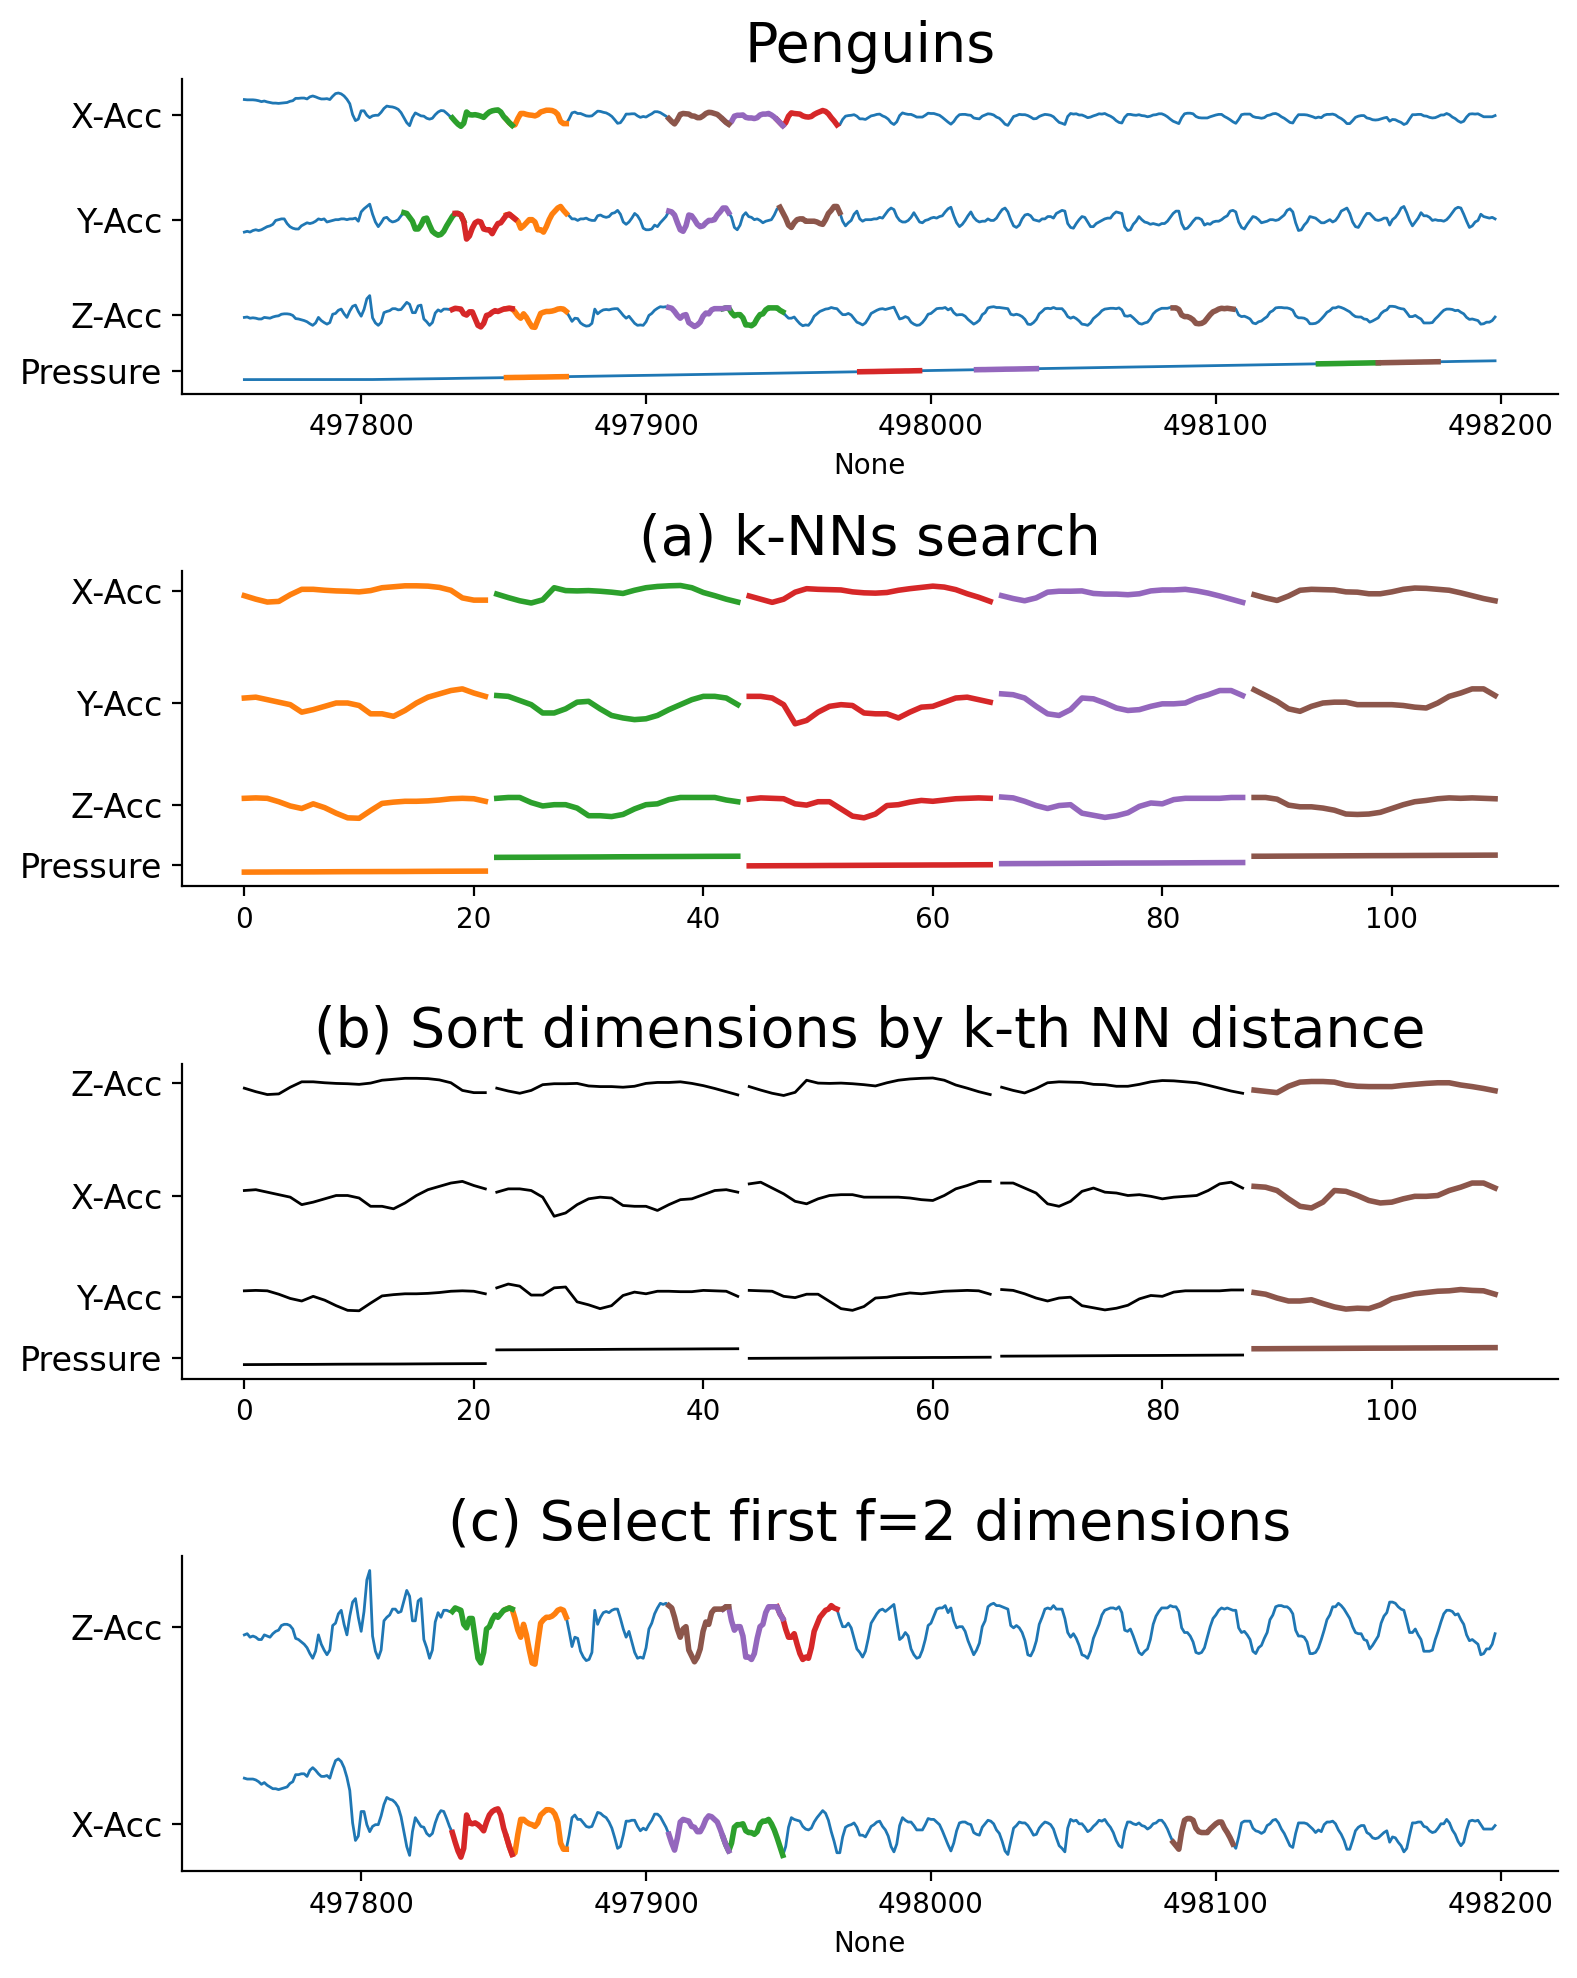

In [6]:
#plot_data(series)
offset = 92
dists = D[:, offset, :]
knn_idx = knns[:, offset, :]
dists_knn = np.take_along_axis(
                dists,
                knn_idx,
                axis=1)
fig, ax = plot_data(series, knn_idx, motif_length, dists, dists_knn)
plt.savefig("images/workflow_choosing_dimension.pdf")